In [1]:
# test for cuda and cudnn
import torch
import os
import shutil
import glob
import yaml
print("version", torch.__version__)
print("cuda available", torch.cuda.is_available())
print("cudnn", torch.backends.cudnn.enabled)
print("device_name", torch.cuda.get_device_name(0))
print("device count", torch.cuda.device_count())
print("current dev", torch.cuda.current_device())
print("device zero", torch.cuda.device(0))


version 2.1.2
cuda available True
cudnn True
device_name NVIDIA GeForce GTX TITAN X
device count 4
current dev 0
device zero <torch.cuda.device object at 0x7f095b9b4580>


## RETRIEVE LOGS

In [2]:
# find runs given a set of cfg parameters: algo.train_every, algo.cnn_keys.encoder, algo.cnn_keys.decoder, algo.mlp_keys.encoder algo.mlp_keys.decoder
import yaml

def find_runs(train_every, cnn_encoder: bool, cnn_decoder: bool, mlp_encoder: bool, mlp_decoder: bool):
    cnn_e = ['rgb'] if cnn_encoder else []
    cnn_d = ['rgb'] if cnn_decoder else []
    mlp_e = ['objects_position'] if mlp_encoder else []
    mlp_d = ['objects_position'] if mlp_decoder else []
    # find all runs
    runs = []
    for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
        for run_dir in glob.glob(os.path.join(game_dir, '*')):
            # get the version_0 directory
            version_dir = os.path.join(run_dir, 'version_0')
            # check if the version directory exists
            if os.path.exists(version_dir):
                # check if config.yaml file exists in the version directory
                for file in os.listdir(version_dir):
                    if file.endswith("config.yaml"):
                        # load config.yaml file
                        config_path = os.path.join(version_dir, file)
                        with open(config_path, 'r') as file:
                            config = yaml.safe_load(file)
                        # print(config["algo"]["train_every"], config["algo"]["train_every"] == train_every)
                        # print(config["algo"]["cnn_keys"]["encoder"], config["algo"]["cnn_keys"]["encoder"] == cnn_e)
                        # print(config["algo"]["cnn_keys"]["decoder"], config["algo"]["cnn_keys"]["decoder"] == cnn_d)
                        # print(config["algo"]["mlp_keys"]["encoder"], config["algo"]["mlp_keys"]["encoder"] == mlp_e)
                        # print(config["algo"]["mlp_keys"]["decoder"], config["algo"]["mlp_keys"]["decoder"] == mlp_d)


                        if config["algo"]["train_every"] == train_every and config["algo"]["cnn_keys"]["encoder"] == cnn_e and config["algo"]["cnn_keys"]["decoder"] == cnn_d and config["algo"]["mlp_keys"]["encoder"] == mlp_e and config["algo"]["mlp_keys"]["decoder"] == mlp_d:
                            runs.append(run_dir)
    print("Runs:")
    for run in runs:
        print(run)

find_runs(2, cnn_encoder=True, cnn_decoder=False, mlp_encoder=True, mlp_decoder=True)



Runs:
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrameskip-v4_3
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-02_13-22-21_dreamer_v3_MsPacmanNoFrameskip-v4_2
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-18_08-42-43_dreamer_v3_MsPacmanNoFrameskip-v4_1
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-01_16-12-40_dreamer_v3_MsPacmanNoFrameskip-v4_1
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-10_06-54-50_dreamer_v3_MsPacmanNoFrameskip-v4_4
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-02-29_19-19-30_dreamer_v3_MsPacmanNoFrameskip-v4_0
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-18_08-12-07_dreamer_v3_MsPacmanNoFrameskip-v4_0
logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-03-18_08-24-30_dreamer_v3_MsPacmanNoFrameskip-v4_2
logs/runs/dreamer_v3/AssaultNoFrameskip-v4/2024-03-07_23-28-02_dreamer_v3_AssaultNoFrameskip-v4_3
logs/runs/dreamer_v3/AssaultNoFrameskip-v4/2024-03-03_00-03-48_dreamer_v3_AssaultNoFrameskip-v4_

In [3]:
count = 0
# print the path of the version directory of each run of each game e.g. for logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-02-09_16-13-45_dreamer_v3_MsPacmanNoFrameskip-v4_0/version_1
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    # skip if not BreakoutNoFrameskip-v4
    if not 'BreakoutNoFrameskip-v4' in game_dir:
        continue
    for run_dir in glob.glob(os.path.join(game_dir, '*')):
        # get the version_0 directory
        version_dir = os.path.join(run_dir, 'version_0')
        # check if the version directory exists
        if os.path.exists(version_dir):
            # check if evaluation directory exists, check if empty. If empty, delete the evaluation dir.
            eval_dir = os.path.join(version_dir, 'evaluation')
            # if dir is empty, print warning
            if os.path.exists(eval_dir) and not os.listdir(eval_dir):
                print("Warning: Empty evaluation directory", eval_dir)


In [4]:
#### CLEAN UP MEMMAP BUFFER FOLDERS ####

date_limit = '2024-03-20'

# Iterate through each EXP_NAME folder
count = 0
for game_dir in glob.glob(os.path.join('logs/runs/dreamer_v3', '*')):
    for exp_dir in glob.glob(os.path.join(game_dir, '*')):
        # stop if exp_dir is more than date_limit
        if exp_dir.split('/')[-1] > date_limit:
            print("Skipping run as too recent: ", exp_dir)
            continue
        version_dir = os.path.join(exp_dir, 'version_0')
        test_videos_path = os.path.join(version_dir, 'test_videos')
        memmap_buffer_path = os.path.join(version_dir, 'memmap_buffer')

        # Check if test_videos exists
        if os.path.exists(test_videos_path) and os.path.isdir(memmap_buffer_path):
            
            count += 1
            # Delete the contents of memmap_buffer
            for file in os.listdir(memmap_buffer_path):
                file_path = os.path.join(memmap_buffer_path, file)
                try:
                    if os.path.isfile(file_path) or os.path.islink(file_path):
                        os.unlink(file_path)
                    elif os.path.isdir(file_path):
                        shutil.rmtree(file_path)
                except Exception as e:
                    print(f"Failed to delete {file_path}. Reason: {e}")
            # delete folder
            #os.rmdir(memmap_buffer_path)

print(f"Total number of experiments processed/memmap deleted: {count}")

Total number of experiments processed/memmap deleted: 0


In [20]:
import os
from cv2 import exp
import yaml
from tensorboard.backend.event_processing import event_accumulator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def create_experiment_df(tensorboard_paths, config_path):
    # Load TensorBoard data
    eas = [event_accumulator.EventAccumulator(x) for x in tensorboard_paths]
    # Load config data
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)

    # get the version number from the tensorboard path
    version = tensorboard_paths[0].split('/')[-2]
    # keep only the digit part of the version
    version = version.split('_')[-1]

    # Extract parameters from config
    def get_ae_keys(mlp_keys: dict, cnn_keys: dict):
        if mlp_keys['encoder'] == []:
            return 'rgb (baseline)'
        elif cnn_keys['encoder'] == []:
            return 'obj'
        elif mlp_keys['decoder'] == ["objects_position"] and cnn_keys['decoder'] == ["rgb"]:
            return 'rgb + obj'
        elif mlp_keys['decoder'] == ["objects_position"] and cnn_keys['decoder'] == []:
            return 'rgb encoding + obj'
        elif mlp_keys['decoder'] == [] and cnn_keys['decoder'] == ["rgb"]:
            return 'rgb + obj encoding'
        else:
            return 'Not found'
    

    params = {
        'seed': config.get('seed', 'Not found'),
        'ae_keys': get_ae_keys(config.get('algo', {}).get('mlp_keys', 'Not found'), config.get('algo', {}).get('cnn_keys', 'Not found')),
        'train_every': config.get('algo', {}).get('train_every', 'Not found'),
        'run_name': config.get('run_name', 'Not found'),
        'buffer_size': config.get('buffer', {}).get('size', 'Not found'),
        'obs_loss_regularizer': config.get('algo', {}).get('world_model', {}).get('obs_loss_regularizer', 1),
        'version': version
    }
    # Extract metrics and populate DataFrame
    list_of_entries = []
    for ea in eas:
        ea.Reload()
        for key in ea.scalars.Keys():
            # skip hp_metric
            if key == 'hp_metric':
                continue
            for event in ea.Scalars(key):
                list_of_entries.append({
                    'Metric': key,
                    'Step': event.step,
                    'Value': event.value,
                    'Seed': params['seed'],
                    'AE_Keys': params['ae_keys'],
                    'Train_Every': params['train_every'],
                    'Run_ID': params['run_name'],
                    'Buffer_Size': params['buffer_size'],
                    'Obs_Loss_Regularizer': params['obs_loss_regularizer'],
                    'Version': params['version']
                })
    df = pd.DataFrame.from_records(list_of_entries, columns=['Metric', 'Step', 'Value', 'Seed', 'AE_Keys', 'Train_Every', 'Run_ID', 'Buffer_Size', 'Obs_Loss_Regularizer', 'Version'])
    return df
                

def process_all_experiments(game_path):
    # Pattern for TensorFlow event files and config files
    tf_event_pattern = 'events.out.tfevents'
    config_filename = 'config.yaml'

    # List to hold DataFrames from each experiment
    experiments_dfs = []

    # Iterate over each subdirectory in the logs directory
    for run_dir in glob.glob(os.path.join(game_path, '*')):
        run_name = run_dir.split('/')[-1]
        for version_dir in glob.glob(os.path.join(run_dir, 'version_*')):
            # find the tf_event file in the first level of the version directory
            # e.g. logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4/2024-02-09_16-13-45_dreamer_v3_MsPacmanNoFrameskip-v4_0/version_0/tf_event_file.
            for file in os.listdir(version_dir):
                if file.startswith(tf_event_pattern):
                    # if file ends in .v2, it's a v2 event file, skip it
                    if file.endswith('.v2'):
                        continue
                    tf_event_paths = [os.path.join(version_dir, file)]
                    config_path = os.path.join(version_dir, config_filename)
                    # This is a completed either a completed training run or a test run 
                    test_path = os.path.join(version_dir, 'test_videos')
                    if not os.path.exists(test_path):
                        continue
                    # Check if config file exists
                    if not os.path.exists(config_path):
                        continue
                    # check if evaluation tf_event file exists. They would be located in version_dir/evaluation/version_* directory
                    eval_dir = os.path.join(version_dir, 'evaluation')
                    if os.path.exists(eval_dir):
                        # iterate over version dirs withinn evaluation dir
                        for eval_version_dir in glob.glob(os.path.join(eval_dir, 'version_*')):
                            for file in os.listdir(eval_version_dir):
                                if file.startswith(tf_event_pattern):
                                    tf_event_path = os.path.join(eval_version_dir, file)
                                    tf_event_paths.append(tf_event_path)
                    experiment_df = create_experiment_df(tf_event_paths, config_path)
                    experiments_dfs.append(experiment_df)

    # Concatenate all DataFrames into a single one
    if len(experiments_dfs) == 0:
       raise ValueError("No experiments found")

    all_experiments_df = pd.concat(experiments_dfs, ignore_index=True)
    print(f"Total number of experiments processed: {len(experiments_dfs)}")
    return all_experiments_df


def rew_barplot(df: pd.DataFrame, env_id: str, train_every: int = 2):
    sns.set_theme(style="whitegrid")
    # Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
    plt.figure(figsize=(10, 6))
    filtered_df = df[(df['Metric']=='Test/cumulative_reward') & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000) & (df['Obs_Loss_Regularizer'] == 1) & (df['Version'] == '0')]
    print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
    filtered_df = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step'])
    sns.set_style("whitegrid")
    # print number of entries for each AE_Keys
    print("Reward Barplot")
    print(len(filtered_df))
    # TODO eval test scores don't seem to be present in the df
    print(filtered_df.groupby('AE_Keys')['Value'].count())


    # Create a bar plot showing the mean score grouped by MLP_Keys
    # Seaborn automatically calculates the confidence interval (95% by default)
    # and adds it as error bars
    plt.figure(figsize=(10, 6))
    sns.barplot(x="AE_Keys", y="Value", data=filtered_df.sort_values('AE_Keys'), errorbar="sd", palette="muted", hue="AE_Keys")

    plt.title(f'Test Cumulative Reward on {env_id.replace("NoFrameskip-v4", "")} trained every {train_every}, grouped by AE_Keys (95% CI)')
    plt.xlabel('AE_Keys')
    plt.ylabel('Mean Test Reward')
    # position y-label on the top left of the plot
    plt.gca().yaxis.set_label_coords(-0.1, 0.5)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.savefig(f'viz/{env_id}/{train_every}_Test_cumulative_reward.png')
    plt.show()
    

def create_viz(df, env_id):
    metrics = df['Metric'].unique()
    train_every_list = df['Train_Every'].unique()
    print(f"Unique train_every: {train_every_list}")
    for train_every in train_every_list:
        if train_every not in [2,8]:
            continue
        print(f"Plotting for train_every: {train_every}")
        for metric in metrics:
            if metric == 'hp_metric' or metric == 'Params/exploration_amount':
                continue
            print(f"Plotting for metric: {metric}")
            if metric == 'Test/cumulative_reward':
                rew_barplot(df, env_id, train_every)
                continue
            # Group by Step and Metric, then calculate mean and std
            filtered_df = df[(df['Metric']==metric) & (df['Train_Every'] == train_every) & (df['Buffer_Size'] == 100000) & (df['Obs_Loss_Regularizer'] == 1) & (df['Version'] == '0')]
            # get number of unique run ids by group of AE_Keys
            print(filtered_df.groupby('AE_Keys')['Run_ID'].nunique())
            grouped = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', ]).groupby(['Step', 'AE_Keys'])
            mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
            # smoothing the plot
            #mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
            #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


            # Plotting
            plt.figure(figsize=(10, 6))

            # Unique AE_Keys
            ae_keys_unique = filtered_df['AE_Keys'].unique()

            for ae_key in sorted(ae_keys_unique):
                subset = mean_std_df[mean_std_df['AE_Keys'] == ae_key]
                # smooth the plot
                #subset['mean'] = subset['mean'].rolling(window=5).mean()
                #subset['std'] = subset['std'].rolling(window=3).mean()
                
                # Plot mean
                plt.plot(subset['Step'], subset['mean'], label=f'AE Keys: {ae_key}')
                
                # Fill between mean ± std
                plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

            plt.title(f'{metric} on {env_id.replace("NoFrameskip-v4", "")}, trained every {train_every}, grouped by AE_Keys')
            plt.xlabel('Step')
            plt.ylabel(f'Average {metric}')
            # log scale for y-axis if metric contains "loss" or "grad"    
            if "Loss" in metric or "Grads" in metric:
                plt.yscale('log')
            else:
                plt.ylim(bottom=0)
            plt.legend()
            plt.savefig(f'viz/{env_id}/{train_every}_{metric.replace("/", "_")}.png')
            if metric == "Rewards/rew_avg" or metric == "Train/cumulative_reward":
                plt.show()
            else:
                plt.close()

def update_viz(game_path):
    all_experiments_df = process_all_experiments(game_path)
    env_id = game_path.split('/')[3]
    # make sure viz/ENV_ID directory exists before saving 
    if not os.path.exists(f'viz/{env_id}'):
        os.makedirs(f'viz/{env_id}')
    create_viz(all_experiments_df, env_id)

## Results

Processing MsPacman...
Total number of experiments processed: 73
Unique train_every: [2 8 1]
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64


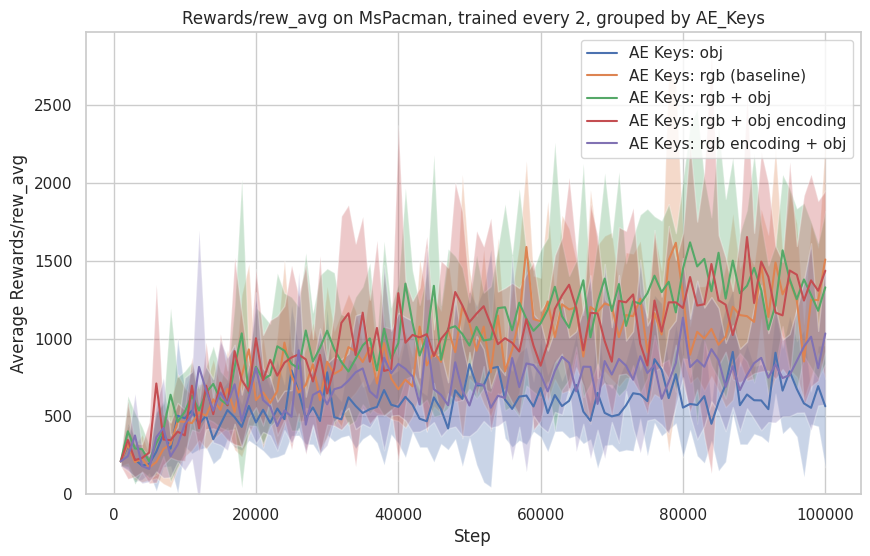

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                    8
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
rgb encoding + obj     8
Name: Run_ID, dtype: int64

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

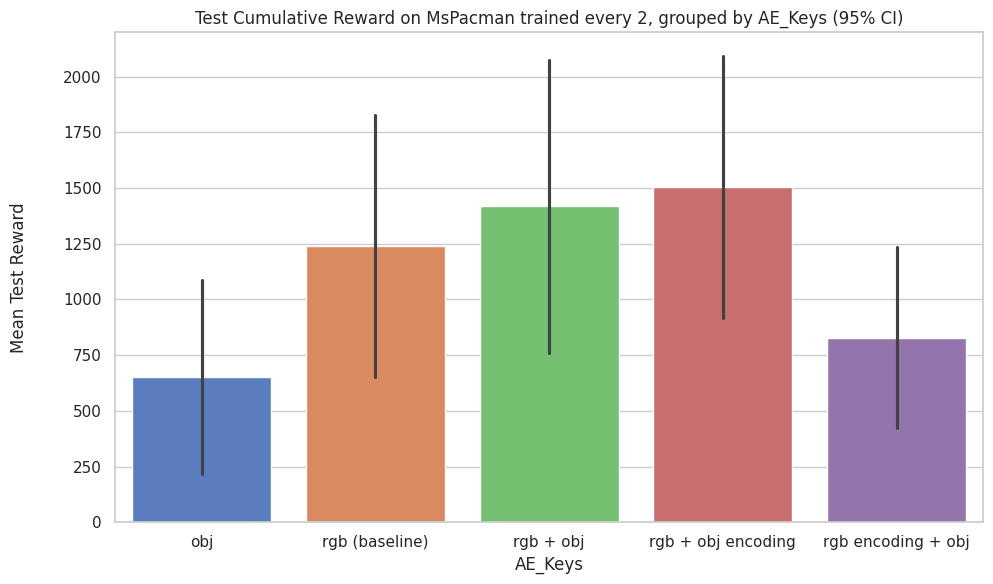

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
rgb (baseline)         8
rgb + obj             11
rgb + obj encoding     8
Name: Run_ID, dtype: int64
Plotting for metric: Train/cumulative_reward
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
rgb encoding + obj    3
Name: Run_ID, dtype: int64


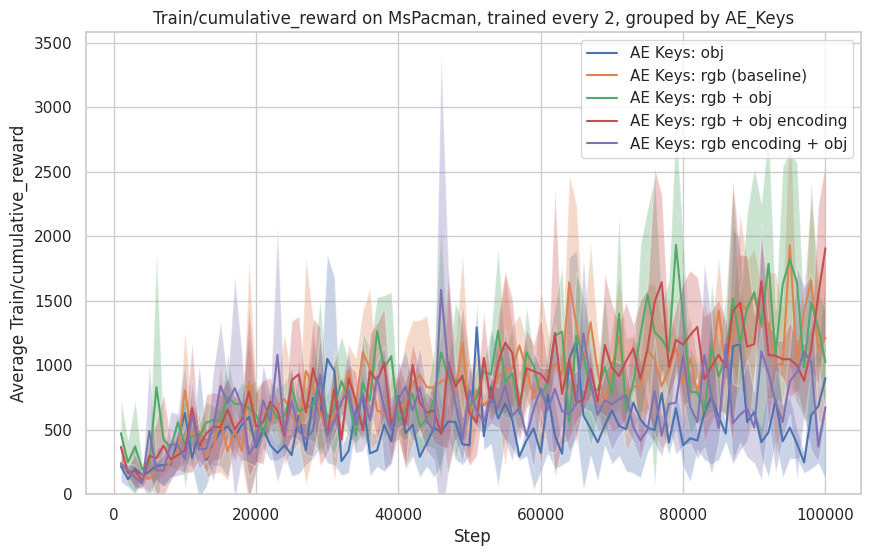

Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64


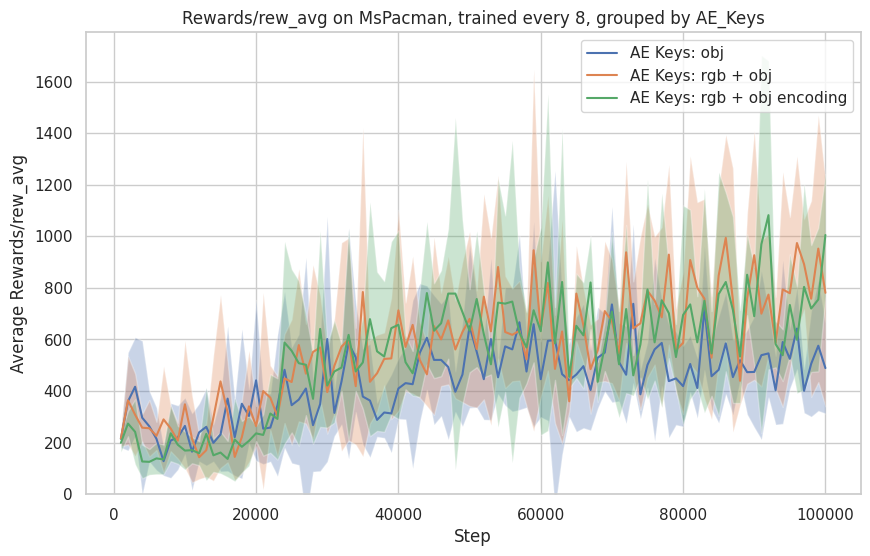

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
obj                   6
rgb + obj             6
rgb + obj encoding  

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

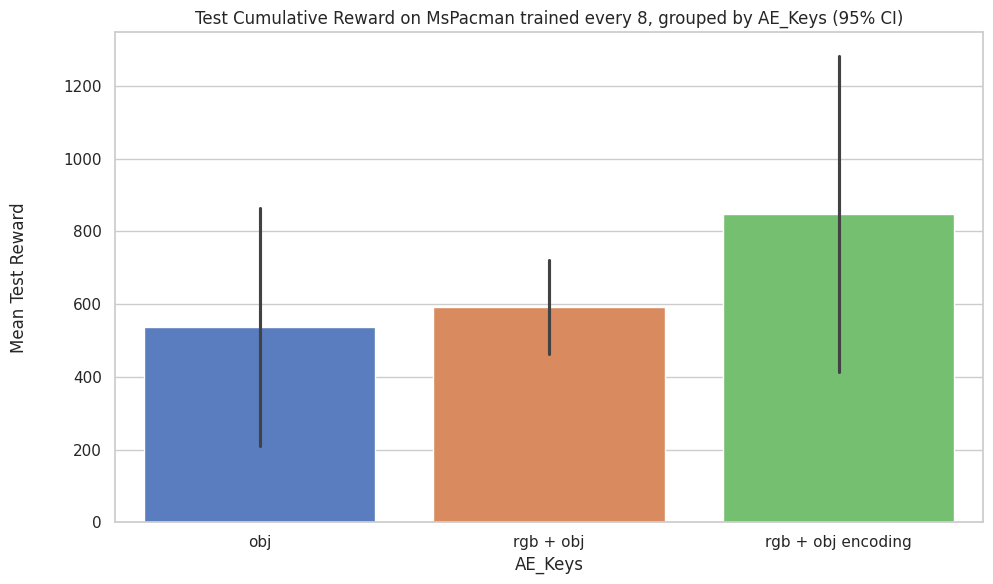

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
rgb + obj             6
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Plotting for metric: Train/cumulative_reward
AE_Keys
rgb + obj    1
Name: Run_ID, dtype: int64


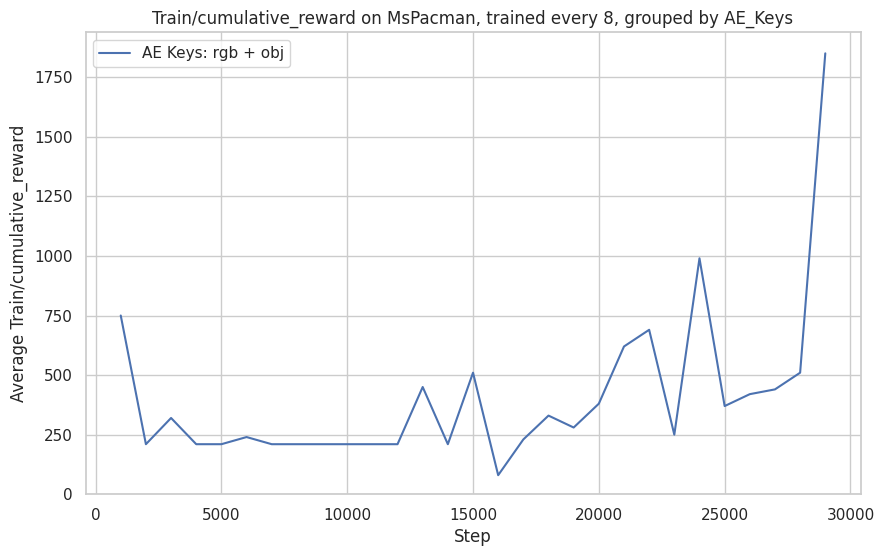

Processing Assault...
Total number of experiments processed: 36
Unique train_every: [8 2]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64


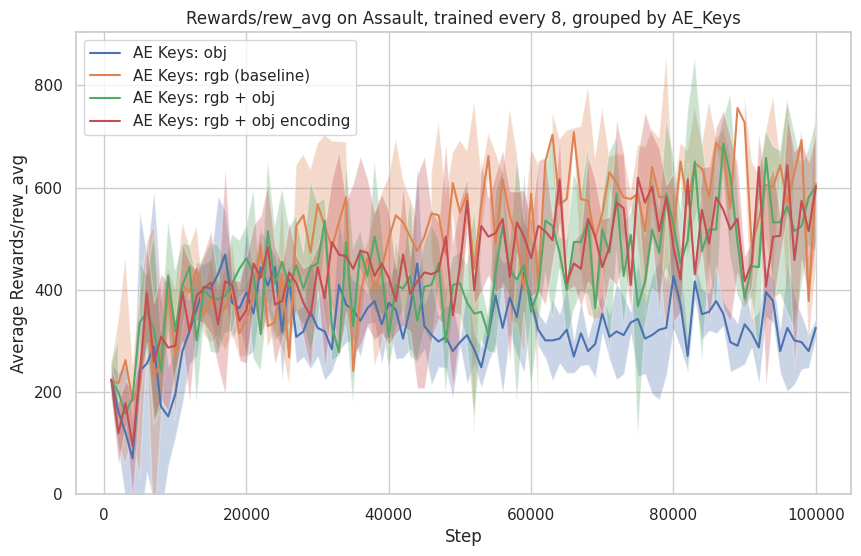

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding   

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

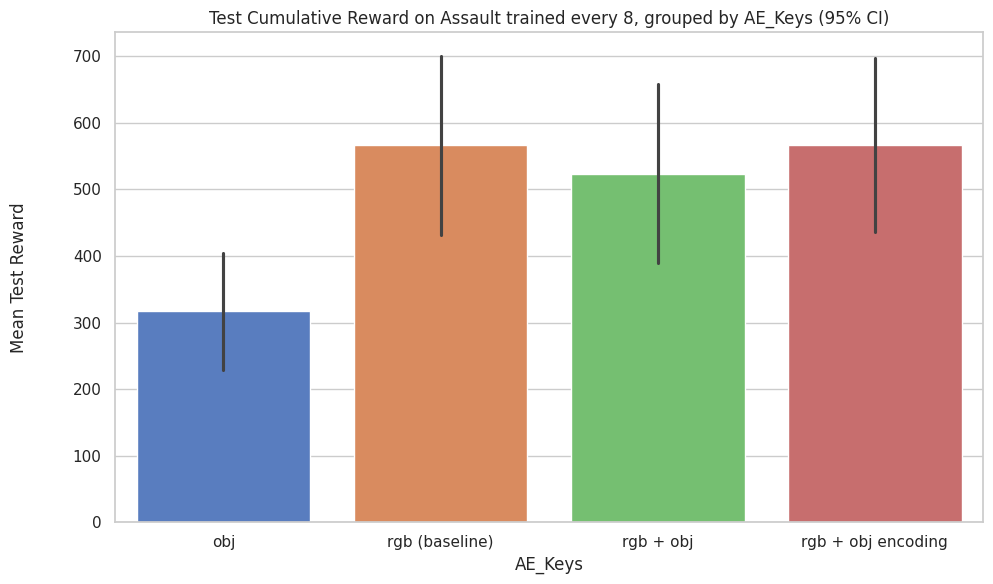

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64


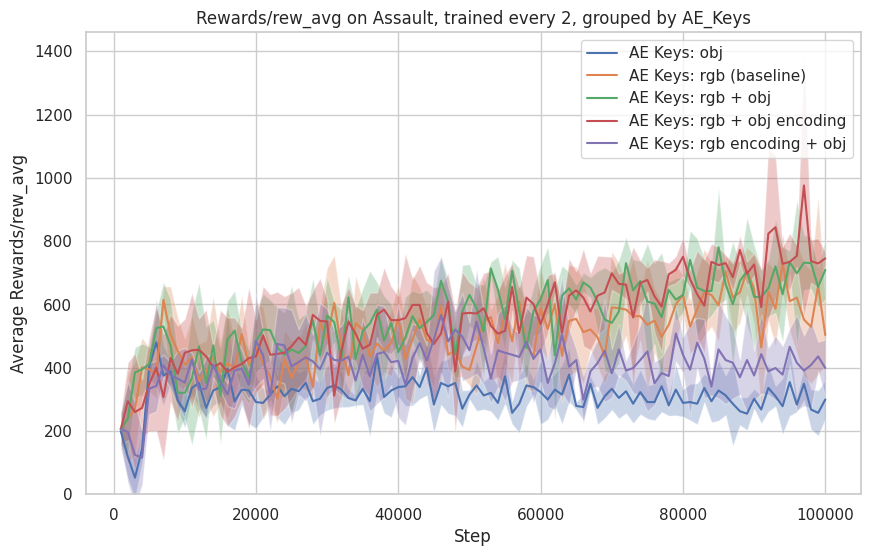

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                   4
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
rgb encoding + obj    5
Name: Run_ID, dtype: int64
Plotting for metric: Los

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

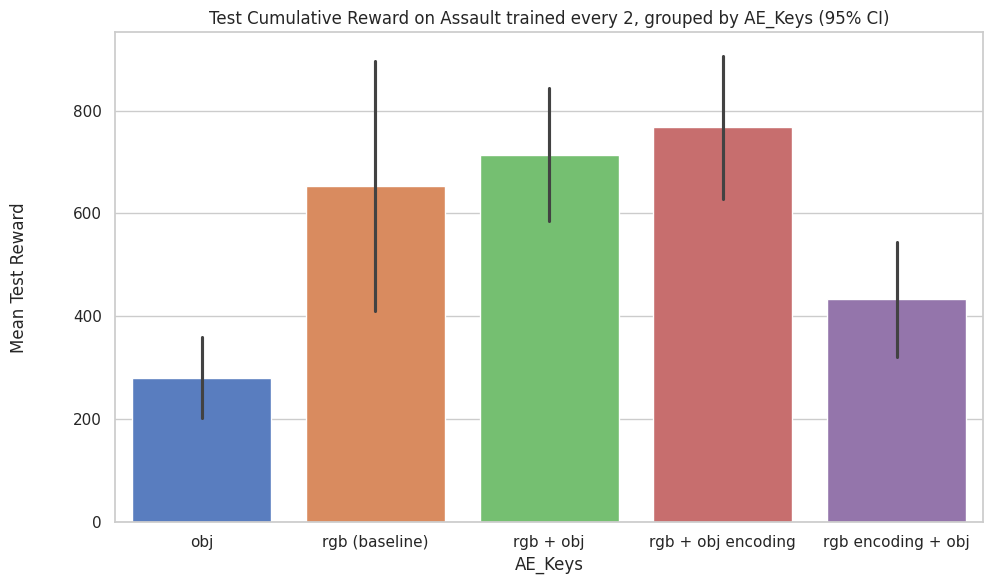

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
rgb (baseline)        5
rgb + obj             5
rgb + obj encoding    5
Name: Run_ID, dtype: int64
Processing Carnival...
Total number of experiments processed: 22
Unique train_every: [8 2]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64


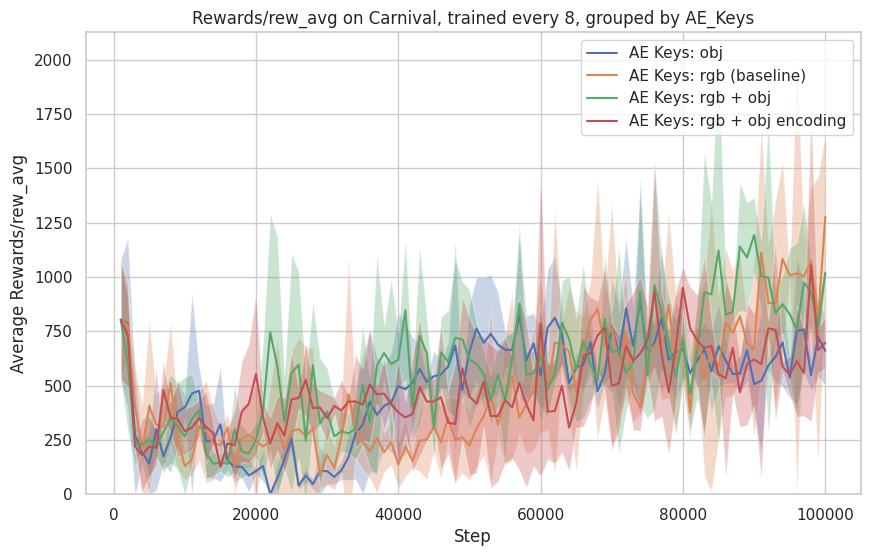

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding    3
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj                   3
rgb (baseline)        3
rgb + obj             3
rgb + obj encoding   

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

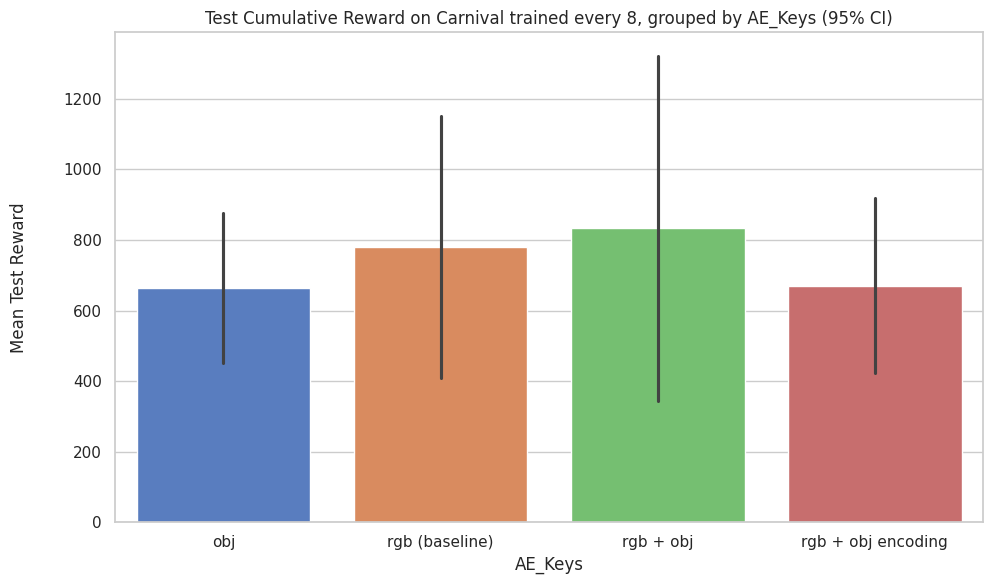

Plotting for train_every: 2
Plotting for metric: Rewards/rew_avg
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64


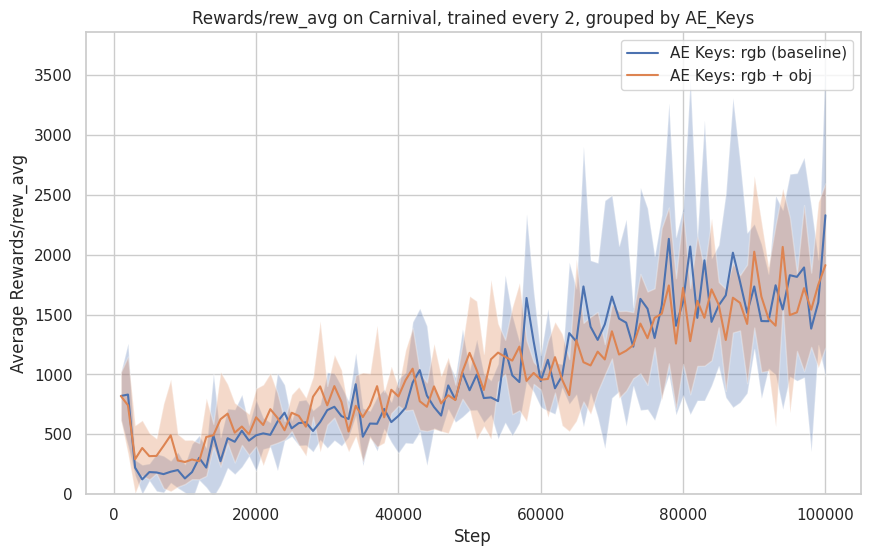

Plotting for metric: Game/ep_len_avg
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/reward_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/state_loss
AE_Keys
rgb (baseline)    5
rgb + obj         5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/continue_loss
AE_Keys
rgb (baseline)    5
rgb + obj    

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 1000x600 with 0 Axes>

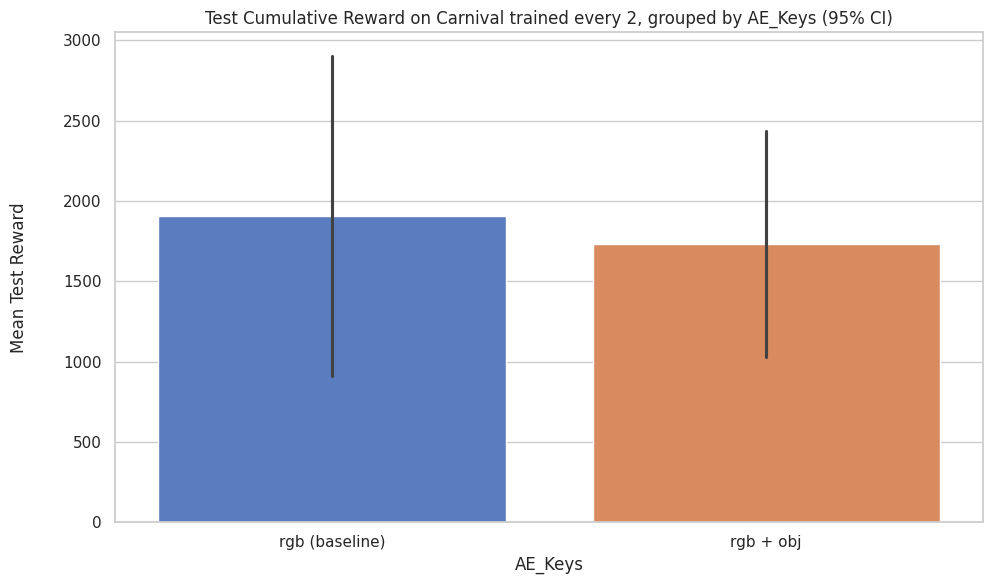

Processing Breakout...
Total number of experiments processed: 26
Unique train_every: [8]
Plotting for train_every: 8
Plotting for metric: Rewards/rew_avg
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64


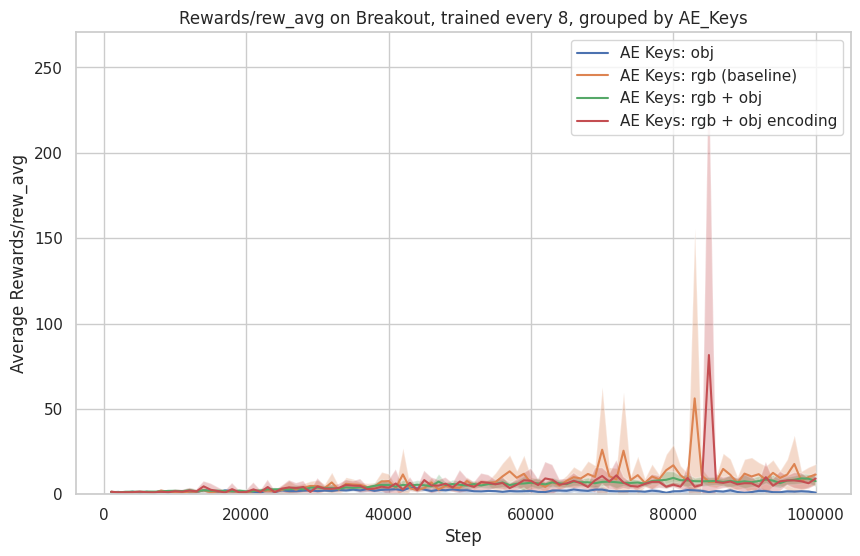

Plotting for metric: Game/ep_len_avg
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64
Plotting for metric: Time/sps_env_interaction
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/world_model_loss
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/value_loss
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/policy_loss
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             10
rgb + obj encoding     5
Name: Run_ID, dtype: int64
Plotting for metric: Loss/observation_loss
AE_Keys
obj                    5
rgb (baseline)         5
rgb + obj             1

/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

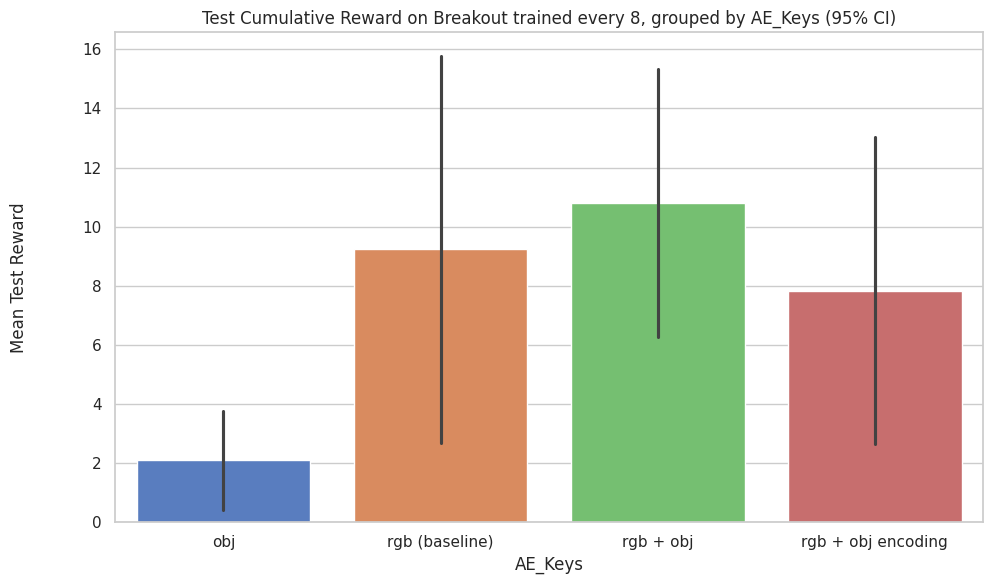

Plotting for metric: Loss/observation_loss_rgb
AE_Keys
rgb + obj    5
Name: Run_ID, dtype: int64


In [21]:
games = ['MsPacman', 'Assault', 'Carnival', 'Breakout']
#games = ['MsPacman']

for game in games:
    print(f"Processing {game}...")
    game_path = f'logs/runs/dreamer_v3/{game}NoFrameskip-v4'
    update_viz(game_path)

# Check test score directly after training and from loaded checkpoints

In [21]:
all_experiments_df = process_all_experiments('logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4')
all_experiments_df

Total number of experiments processed: 57


Metric  Step   Value  Seed             AE_Keys  \
0              Rewards/rew_avg  1000   200.0     3  rgb encoding + obj   
1              Rewards/rew_avg  2000   270.0     3  rgb encoding + obj   
2              Rewards/rew_avg  3000   235.0     3  rgb encoding + obj   
3              Rewards/rew_avg  4000   105.0     3  rgb encoding + obj   
4              Rewards/rew_avg  5000    70.0     3  rgb encoding + obj   
...                        ...   ...     ...   ...                 ...   
110968  Test/cumulative_reward     0  1160.0     2                 obj   
110969  Test/cumulative_reward     0   370.0     2                 obj   
110970  Test/cumulative_reward     0   340.0     2                 obj   
110971  Test/cumulative_reward     0   330.0     2                 obj   
110972  Test/cumulative_reward     0   490.0     2                 obj   

        Train_Every                                             Run_ID  \
0                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
1                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
2                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
3                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
4                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
...             ...                                                ...   
110968            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110969            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110970            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110971            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110972            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   

        Buffer_Size  Obs_Loss_Regularizer Version  
0            100000                   1.0       0  
1            100000                   1.0       0  
2            100000                   1.0       0  
3            100000                   1.0       0  
4            100000                   1.0       0  
...             ...                   ...     ...  
110968       100000                   1.0       0  
110969       100000                   1.0       0  
110970       100000                   1.0       0  
110971       100000                   1.0       0  
110972       100000                   1.0       0  

[110973 rows x 10 columns]

In [22]:
# check values of version
all_experiments_df['Version'].unique()

array(['0'], dtype=object)

Version
0    740
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


<Figure size 1000x600 with 0 Axes>

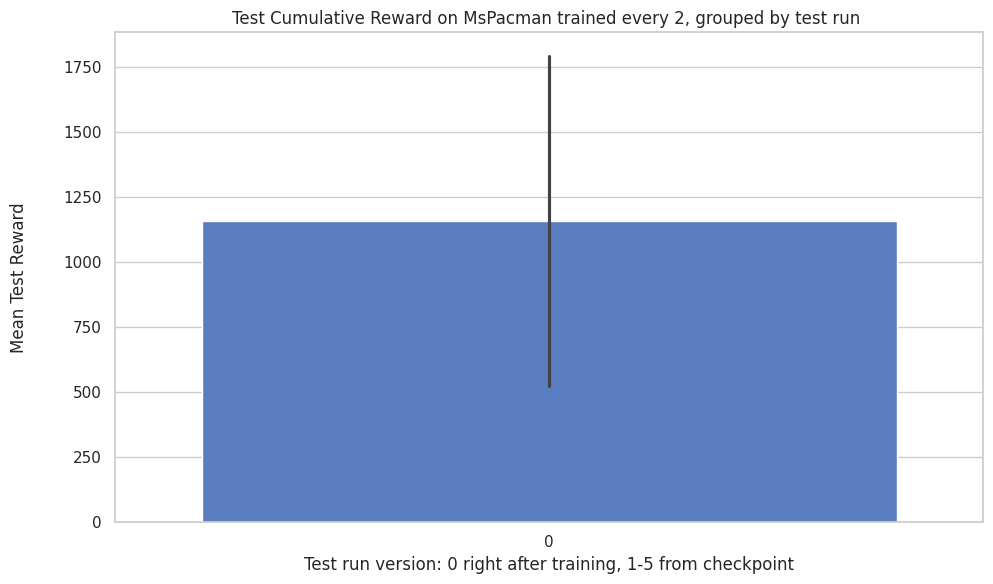

In [23]:
filtered_df = all_experiments_df[(all_experiments_df['Metric'] == 'Test/cumulative_reward') & (all_experiments_df['Train_Every'] == 2) & (all_experiments_df['Buffer_Size'] == 100000)]
# Plotting
sns.set_theme(style="whitegrid")
# Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
plt.figure(figsize=(10, 6))
metric_df = filtered_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step', 'Buffer_Size'])
sns.set_style("whitegrid")
# print number of entries for each AE_Keys
print(metric_df.groupby('Version')['Value'].count())


# Create a bar plot showing the mean score grouped by MLP_Keys
# Seaborn automatically calculates the confidence interval (95% by default)
# and adds it as error bars
plt.figure(figsize=(10, 6))
sns.barplot(x="Version", y="Value", data=metric_df.sort_values('Version'), errorbar="sd", palette="muted", hue="Version")

plt.title(f'Test Cumulative Reward on MsPacman trained every 2, grouped by test run ')
plt.xlabel('Test run version: 0 right after training, 1-5 from checkpoint')
plt.ylabel('Mean Test Reward')
# position y-label on the top left of the plot
plt.gca().yaxis.set_label_coords(-0.1, 0.5)

plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
plt.savefig(f'Progress_investigation_Test_cumulative_reward_version.png')
plt.show()

# Object loss scaling

In [24]:
all_experiments_df = process_all_experiments('logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4')

Total number of experiments processed: 57


In [25]:
all_experiments_df

Metric  Step   Value  Seed             AE_Keys  \
0              Rewards/rew_avg  1000   200.0     3  rgb encoding + obj   
1              Rewards/rew_avg  2000   270.0     3  rgb encoding + obj   
2              Rewards/rew_avg  3000   235.0     3  rgb encoding + obj   
3              Rewards/rew_avg  4000   105.0     3  rgb encoding + obj   
4              Rewards/rew_avg  5000    70.0     3  rgb encoding + obj   
...                        ...   ...     ...   ...                 ...   
110968  Test/cumulative_reward     0  1160.0     2                 obj   
110969  Test/cumulative_reward     0   370.0     2                 obj   
110970  Test/cumulative_reward     0   340.0     2                 obj   
110971  Test/cumulative_reward     0   330.0     2                 obj   
110972  Test/cumulative_reward     0   490.0     2                 obj   

        Train_Every                                             Run_ID  \
0                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
1                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
2                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
3                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
4                 2  2024-03-07_22-59-34_dreamer_v3_MsPacmanNoFrame...   
...             ...                                                ...   
110968            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110969            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110970            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110971            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   
110972            8  2024-02-08_19-04-12_dreamer_v3_MsPacmanNoFrame...   

        Buffer_Size  Obs_Loss_Regularizer Version  
0            100000                   1.0       0  
1            100000                   1.0       0  
2            100000                   1.0       0  
3            100000                   1.0       0  
4            100000                   1.0       0  
...             ...                   ...     ...  
110968       100000                   1.0       0  
110969       100000                   1.0       0  
110970       100000                   1.0       0  
110971       100000                   1.0       0  
110972       100000                   1.0       0  

[110973 rows x 10 columns]

Plotting for metric: Rewards/rew_avg
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


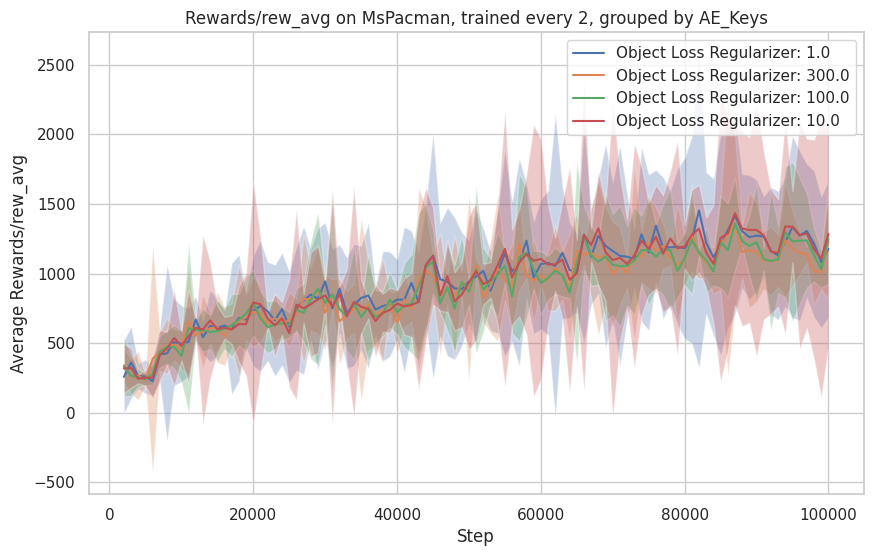

Plotting for metric: Game/ep_len_avg
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


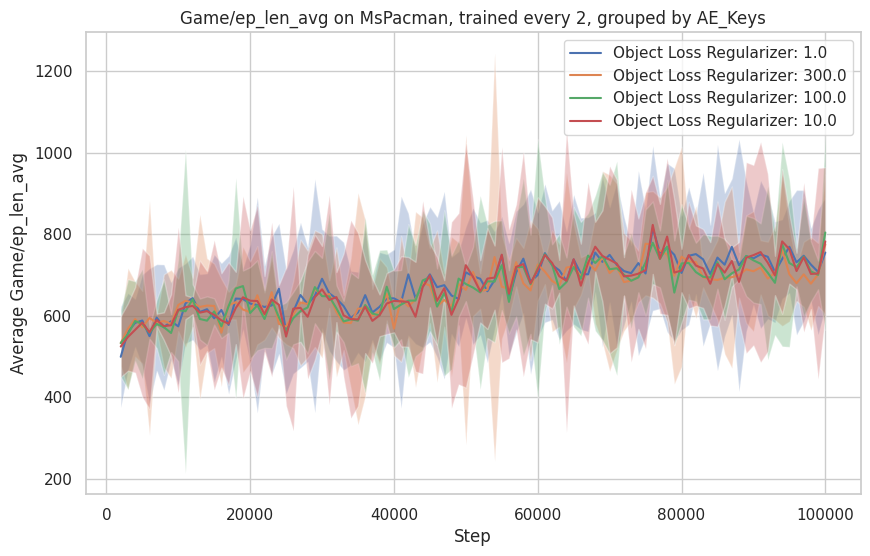

Plotting for metric: Time/sps_env_interaction
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


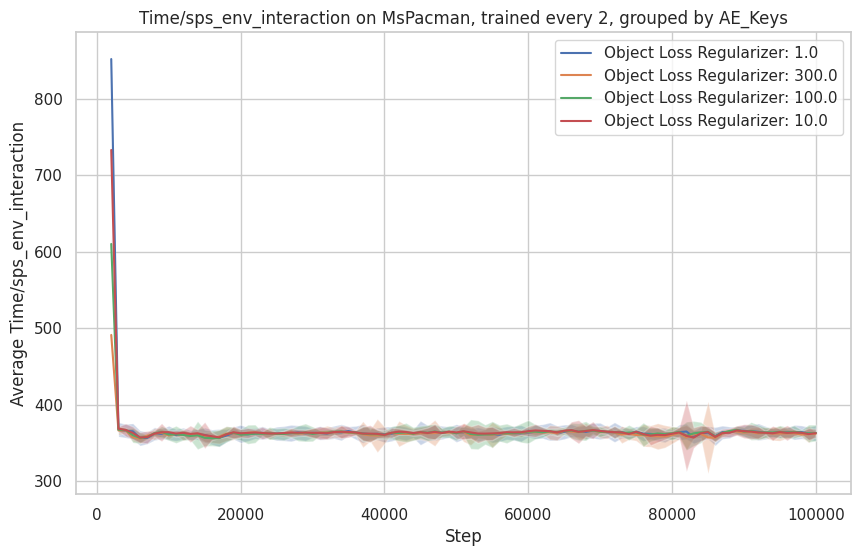

Plotting for metric: Loss/world_model_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


Plotting for metric: Loss/value_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


Plotting for metric: Loss/policy_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


Plotting for metric: Loss/observation_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


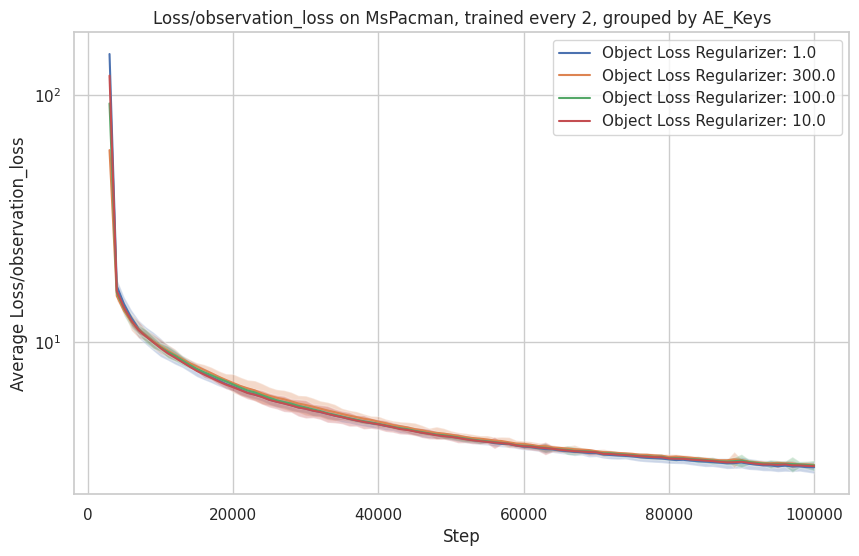

Plotting for metric: Loss/reward_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


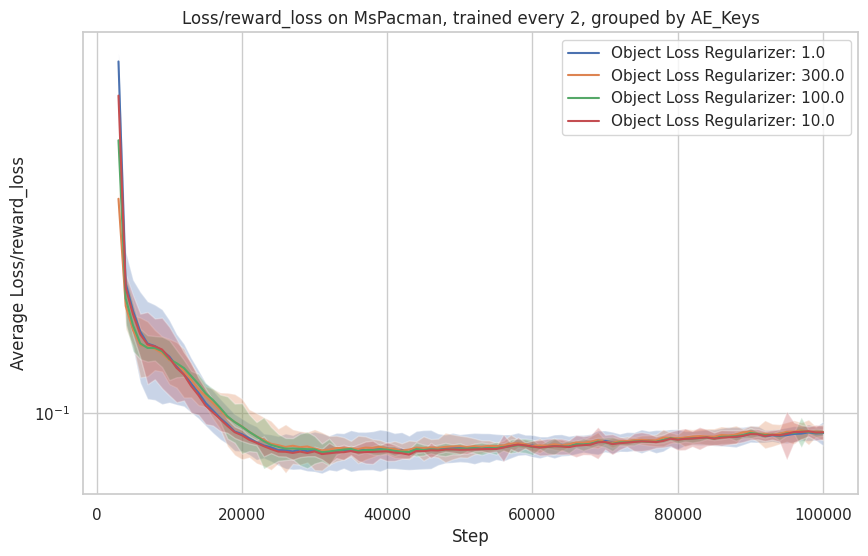

Plotting for metric: Loss/state_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


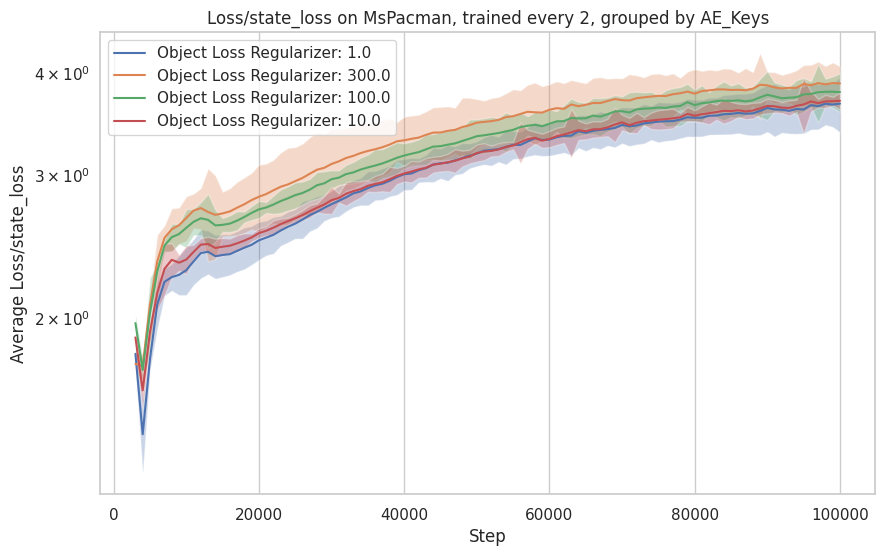

Plotting for metric: Loss/continue_loss
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


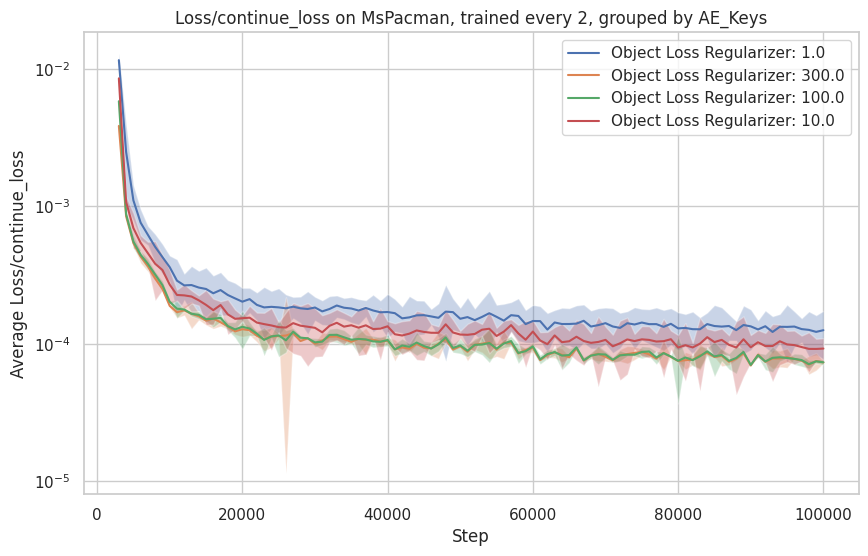

Plotting for metric: State/kl
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


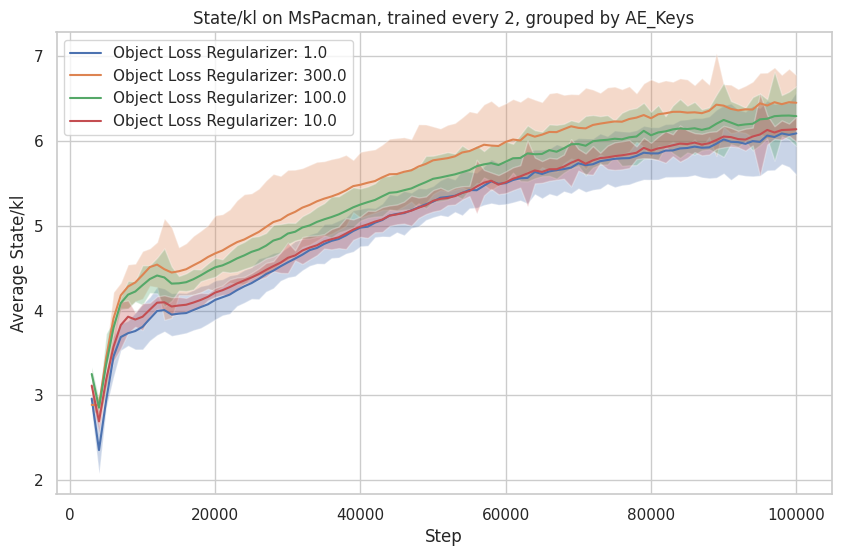

Plotting for metric: State/post_entropy
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


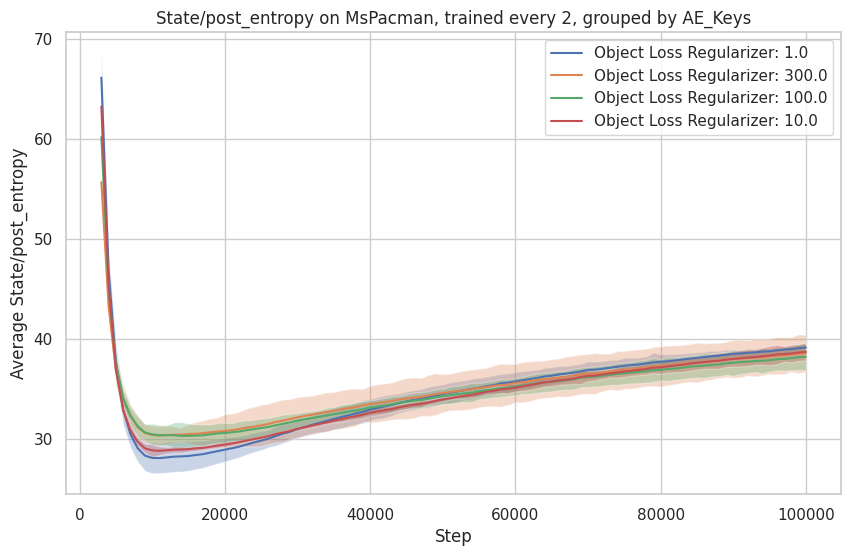

Plotting for metric: State/prior_entropy
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


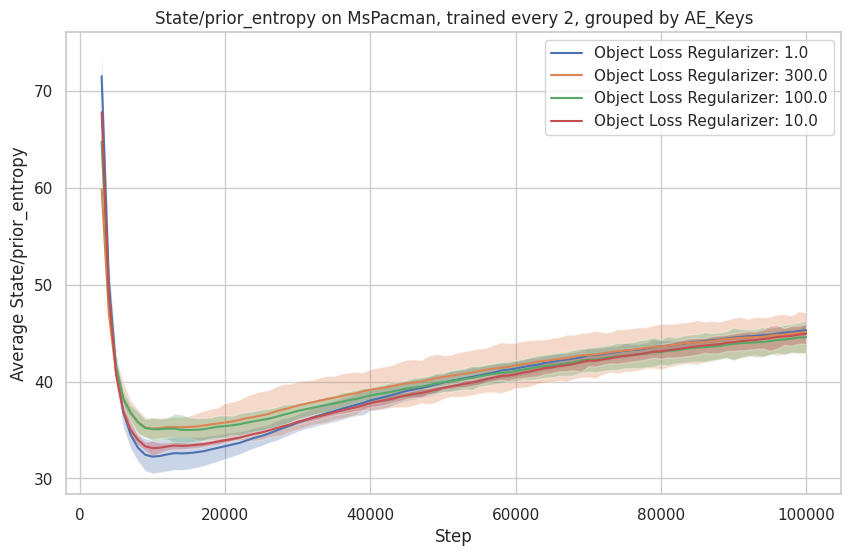

Plotting for metric: Grads/world_model
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


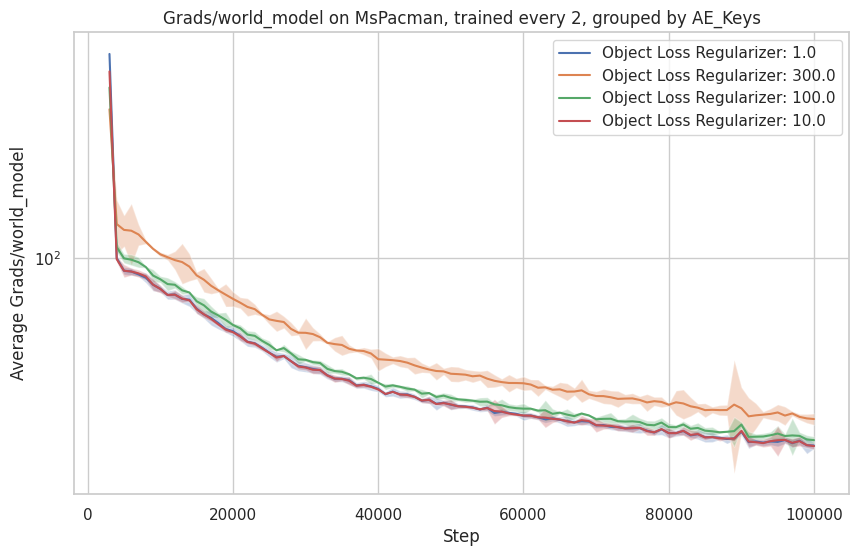

Plotting for metric: Grads/actor
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


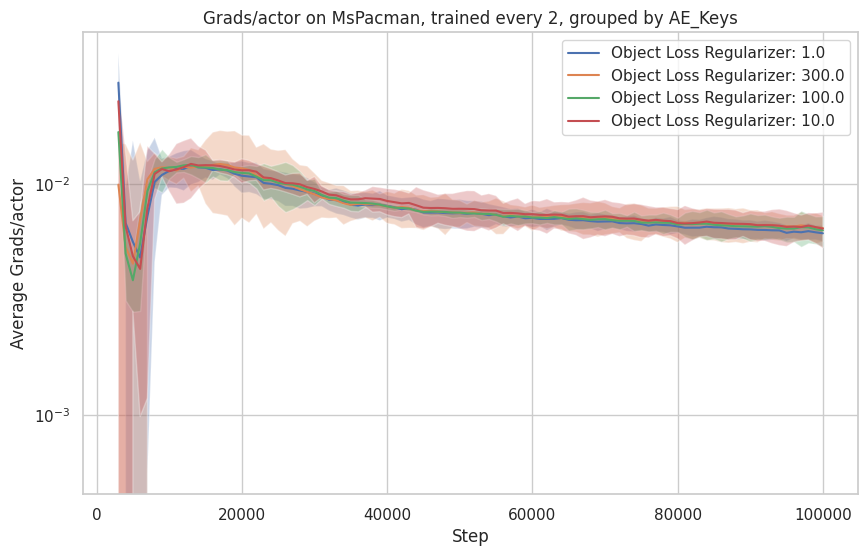

Plotting for metric: Grads/critic
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


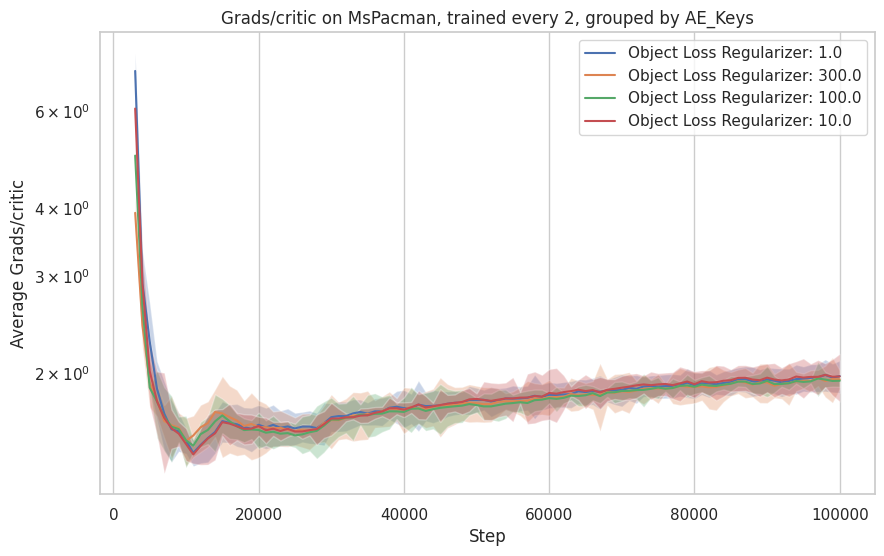

Plotting for metric: Loss/observation_loss_rgb
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


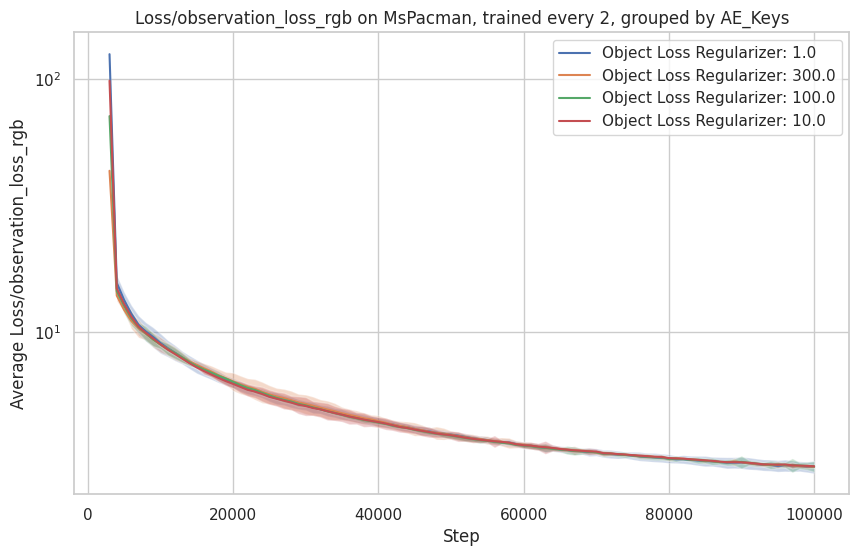

Plotting for metric: Loss/observation_loss_objects_position
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


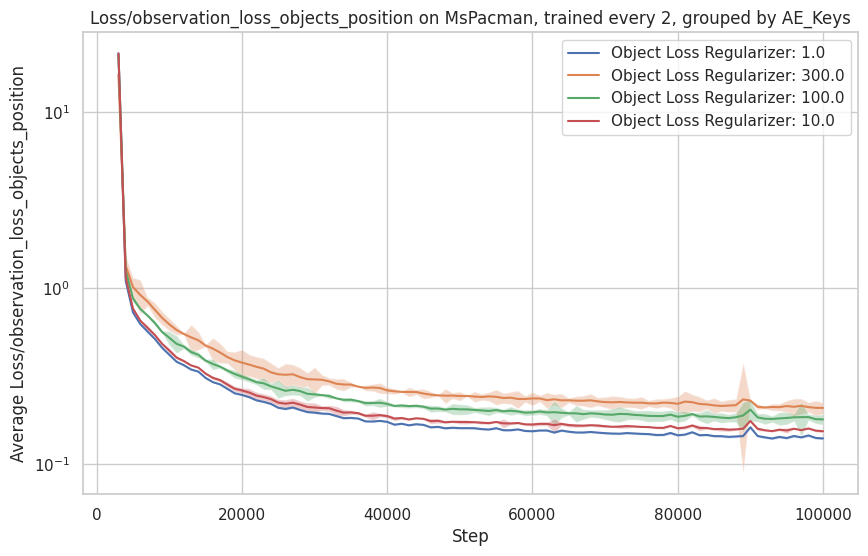

Plotting for metric: Time/sps_train
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64


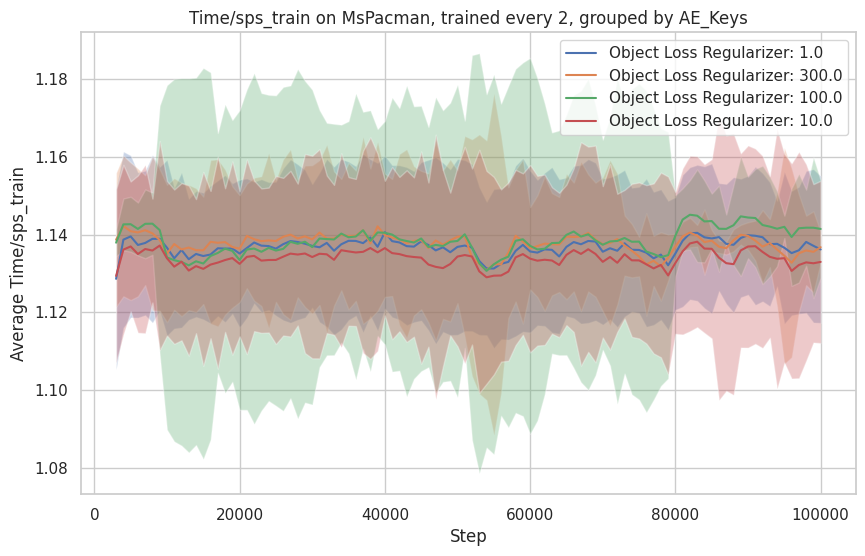

Plotting for metric: Test/cumulative_reward
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64
Obs_Loss_Regularizer
1.0      8
10.0     3
100.0    3
300.0    3
Name: Run_ID, dtype: int64
Obs_Loss_Regularizer
1.0      160
10.0      60
100.0     60
300.0     60
Name: Value, dtype: int64


/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/local/home/keblin/miniconda3/envs/sheep/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(

<Figure size 1000x600 with 0 Axes>

In [26]:
# unique runs by Buffer_Size, filter AE_Keys = obj_autoencoding and Train_Every=2
filtered_df = all_experiments_df[(all_experiments_df['AE_Keys'] == 'rgb + obj') & (all_experiments_df['Train_Every'] == 2) & (all_experiments_df['Buffer_Size'] == 100000) & (all_experiments_df['Version'] == '0')]
metrics = filtered_df['Metric'].unique()
for metric in metrics:
    if metric == 'hp_metric' or metric == 'Params/exploration_amount':
        continue
    print(f"Plotting for metric: {metric}")

    # Group by Step and Metric, then calculate mean and std
    metric_df = filtered_df[(filtered_df['Metric']==metric)]
    # get number of unique run ids by group of AE_Keys
    print(metric_df.groupby('Obs_Loss_Regularizer')['Run_ID'].nunique())
    grouped = metric_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Buffer_Size']).groupby(['Step', 'Obs_Loss_Regularizer'])
    mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
    # smoothing the plot
    mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
    #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


    # Plotting
    if metric == 'Test/cumulative_reward':
        sns.set_theme(style="whitegrid")
        # Plot bar plot of Test/cumulative_reward grouped by MLP_Keys, show mean and confidence interval
        plt.figure(figsize=(10, 6))
        print(metric_df.groupby('Obs_Loss_Regularizer')['Run_ID'].nunique())
        metric_df = metric_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed', 'Step', 'Buffer_Size'])
        sns.set_style("whitegrid")
        # print number of entries for each AE_Keys
        print(metric_df.groupby('Obs_Loss_Regularizer')['Value'].count())


        # Create a bar plot showing the mean score grouped by MLP_Keys
        # Seaborn automatically calculates the confidence interval (95% by default)
        # and adds it as error bars
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Obs_Loss_Regularizer", y="Value", data=metric_df.sort_values('Obs_Loss_Regularizer'), errorbar="sd", palette="muted", hue="Obs_Loss_Regularizer")

        plt.title(f'Test Cumulative Reward on MsPacman trained every 2, grouped by Obs_Loss_Regularizer (95% CI)')
        plt.xlabel('Obs_Loss_Regularizer')
        plt.ylabel('Mean Test Reward')
        # position y-label on the top left of the plot
        plt.gca().yaxis.set_label_coords(-0.1, 0.5)

        plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
        plt.show()
        continue

    plt.figure(figsize=(10, 6))
    # Unique AE_Keys
    loss_reg_unique = filtered_df['Obs_Loss_Regularizer'].unique()
    for loss_reg in loss_reg_unique:
        subset = mean_std_df[mean_std_df['Obs_Loss_Regularizer'] == loss_reg]
        
        # Plot mean
        plt.plot(subset['Step'], subset['mean'], label=f'Object Loss Regularizer: {loss_reg}')
        
        # Fill between mean ± std
        plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

    plt.title(f'{metric} on MsPacman, trained every 2, grouped by AE_Keys')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    # log scale for y-axis if metric contains "loss" or "grad"    
    if "Loss" in metric or "Grads" in metric:
        plt.yscale('log')
    plt.legend()
    plt.show()

# Buffer 10K

In [27]:
all_experiments_df = process_all_experiments('logs/runs/dreamer_v3/MsPacmanNoFrameskip-v4')

Total number of experiments processed: 57


Plotting for metric: Rewards/rew_avg
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


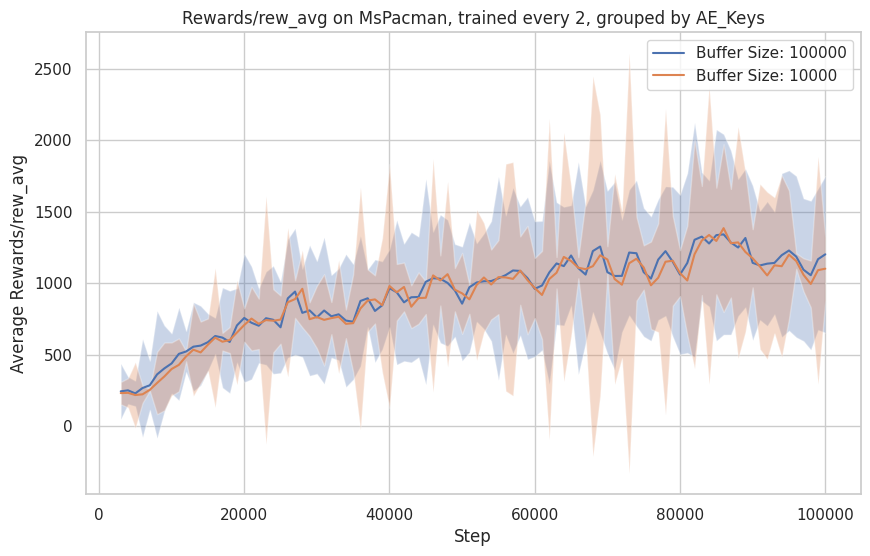

Plotting for metric: Game/ep_len_avg
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


Plotting for metric: Time/sps_env_interaction
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


Plotting for metric: Loss/world_model_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


Plotting for metric: Loss/value_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


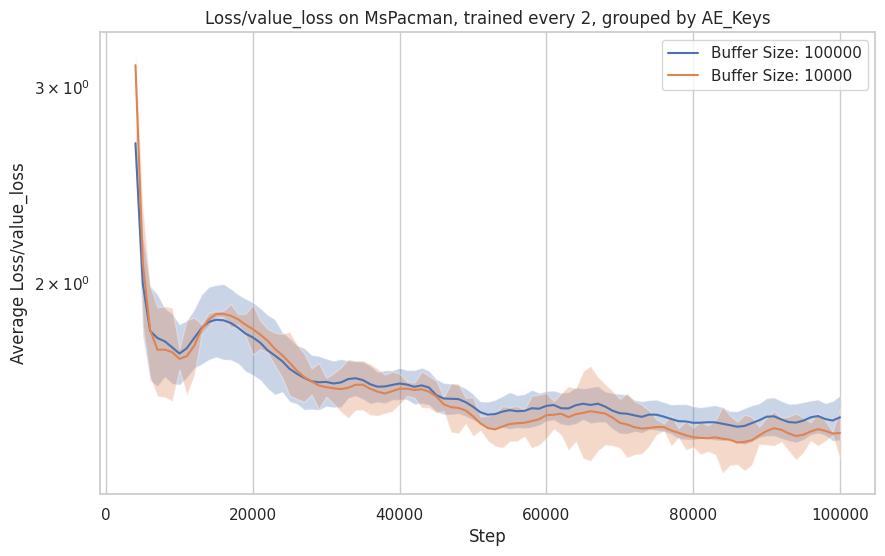

Plotting for metric: Loss/policy_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


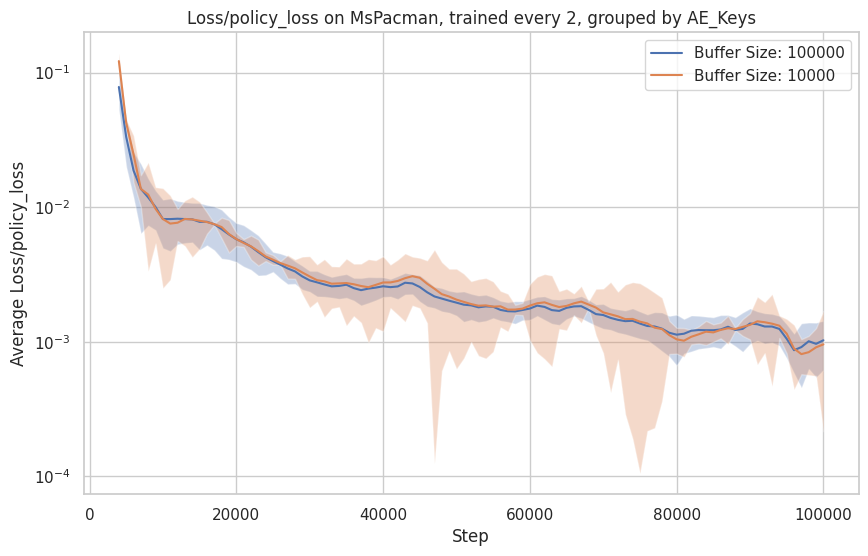

Plotting for metric: Loss/observation_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


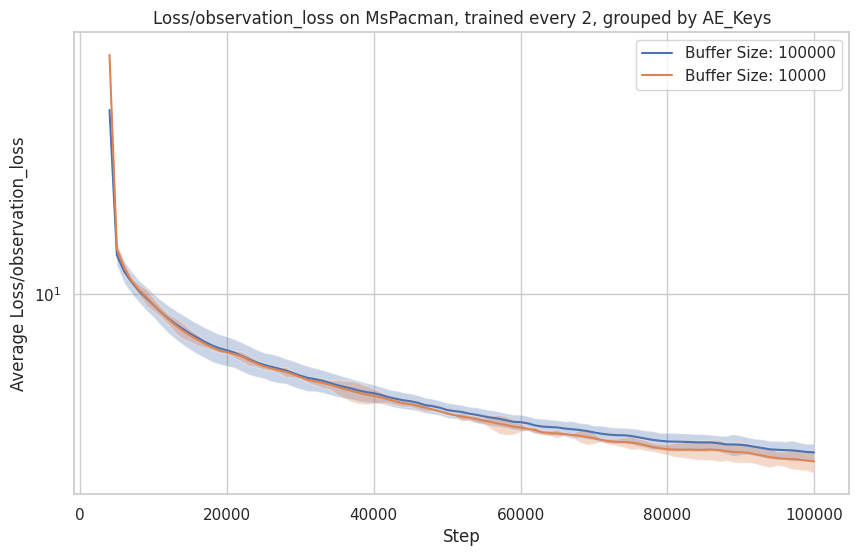

Plotting for metric: Loss/reward_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


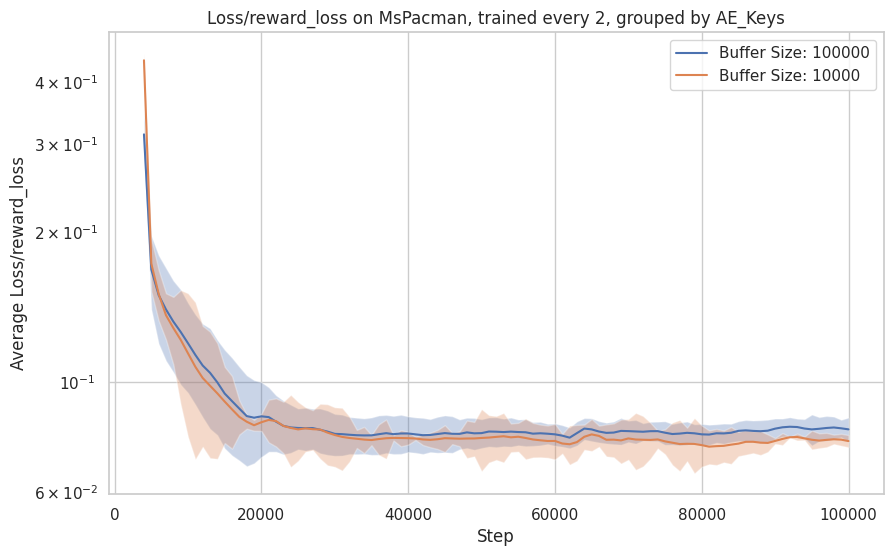

Plotting for metric: Loss/state_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


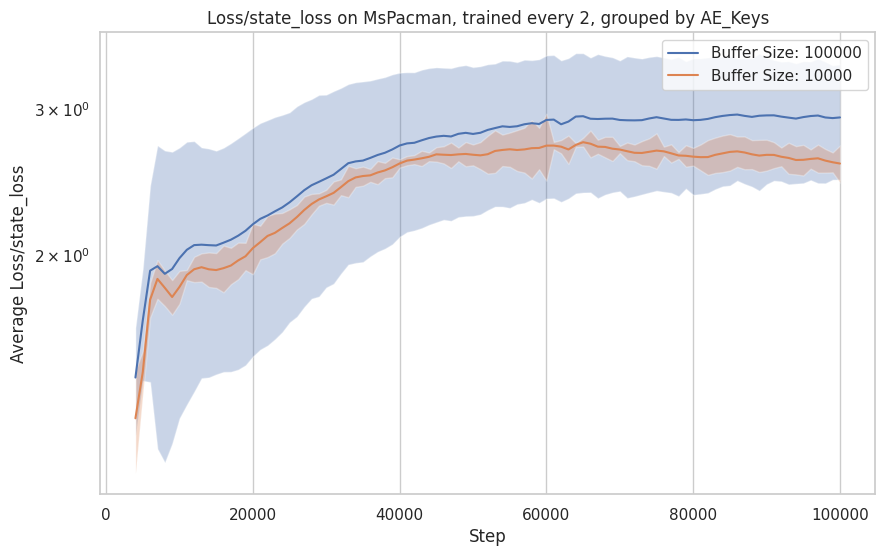

Plotting for metric: Loss/continue_loss
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


Plotting for metric: State/kl
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


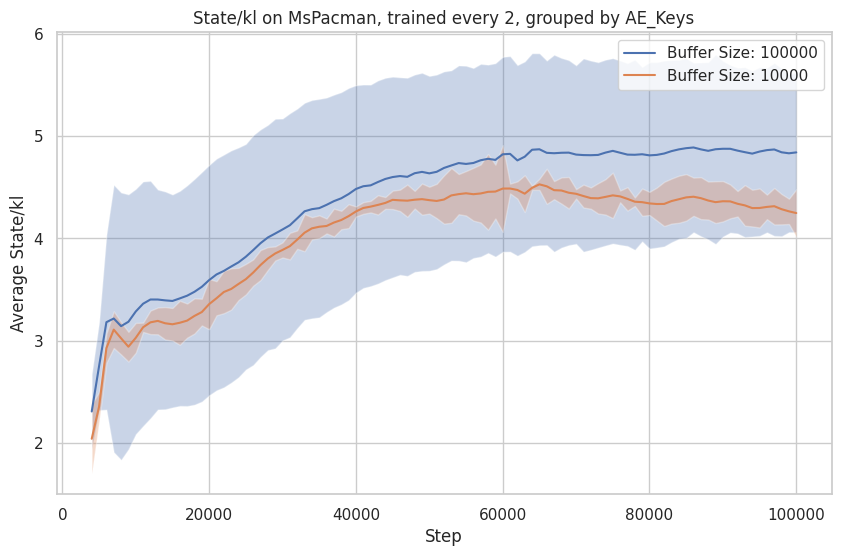

Plotting for metric: State/post_entropy
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


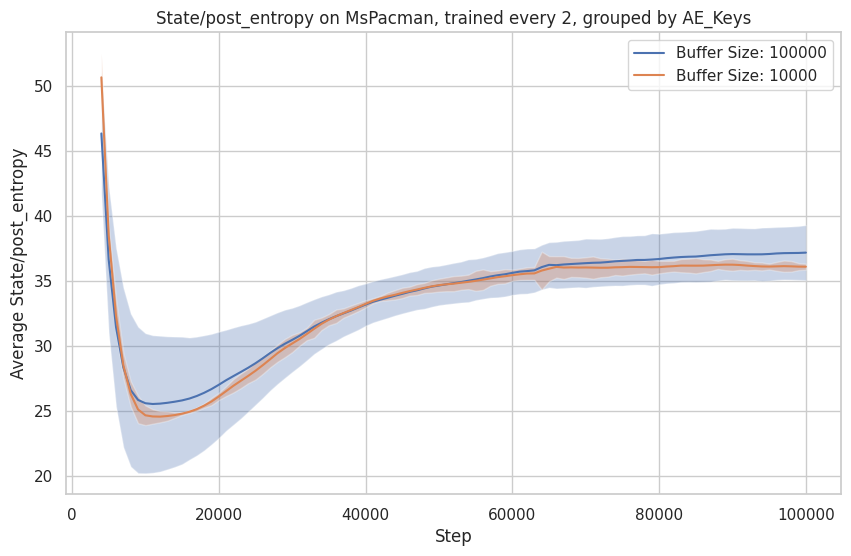

Plotting for metric: State/prior_entropy
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


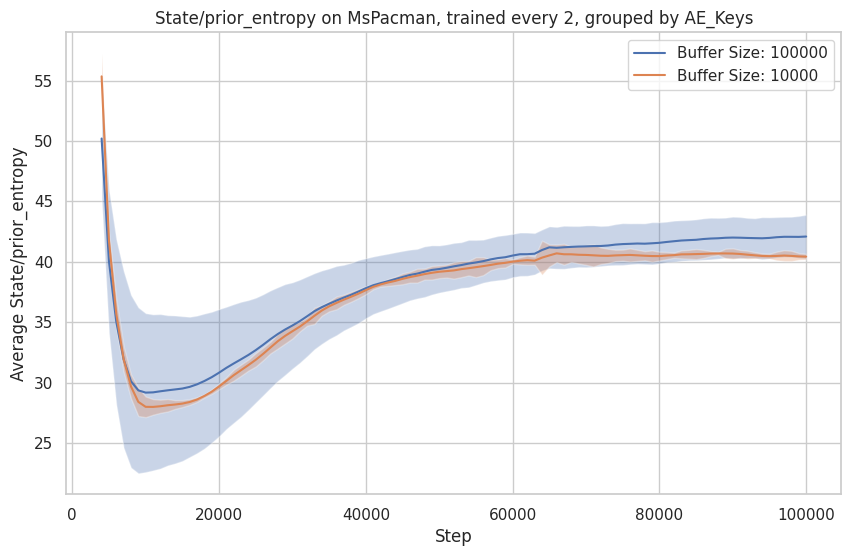

Plotting for metric: Grads/world_model
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


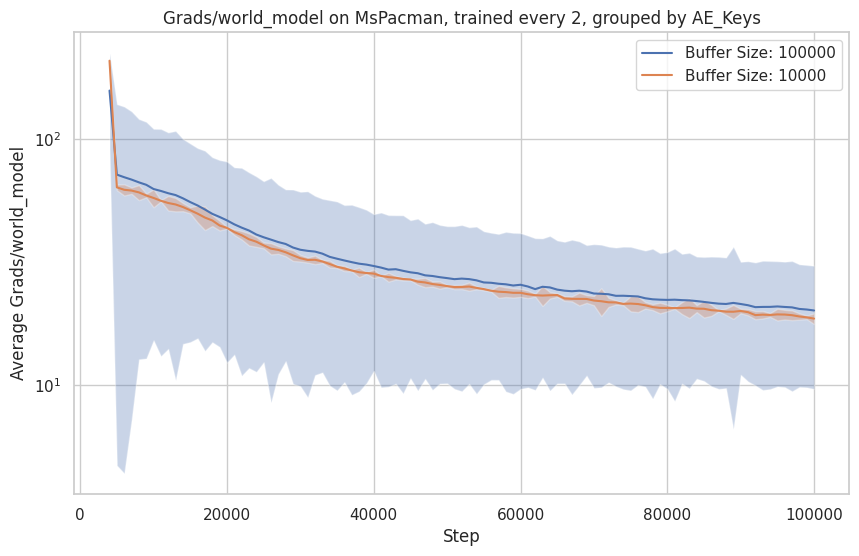

Plotting for metric: Grads/actor
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


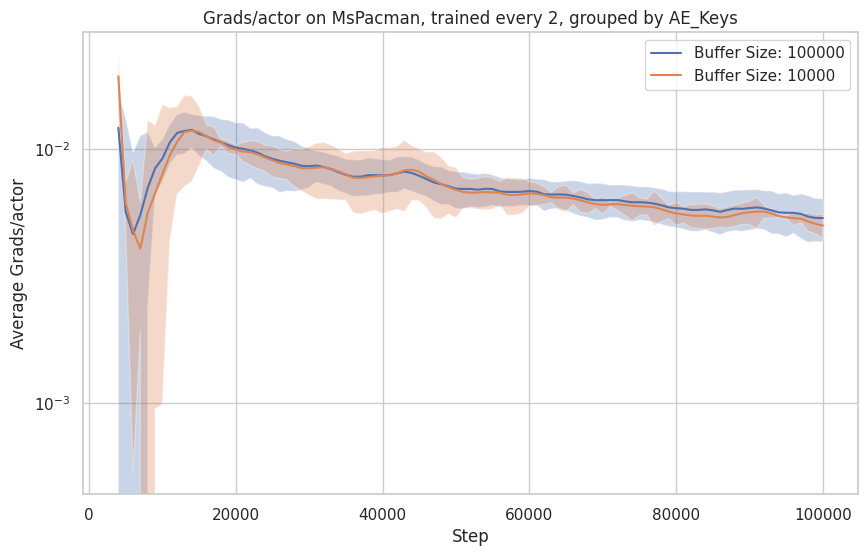

Plotting for metric: Grads/critic
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


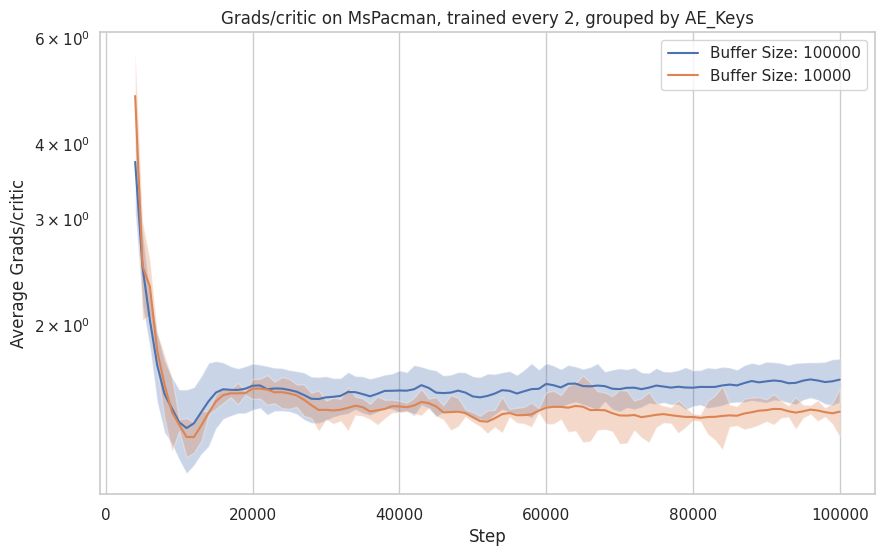

Plotting for metric: Loss/observation_loss_rgb
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


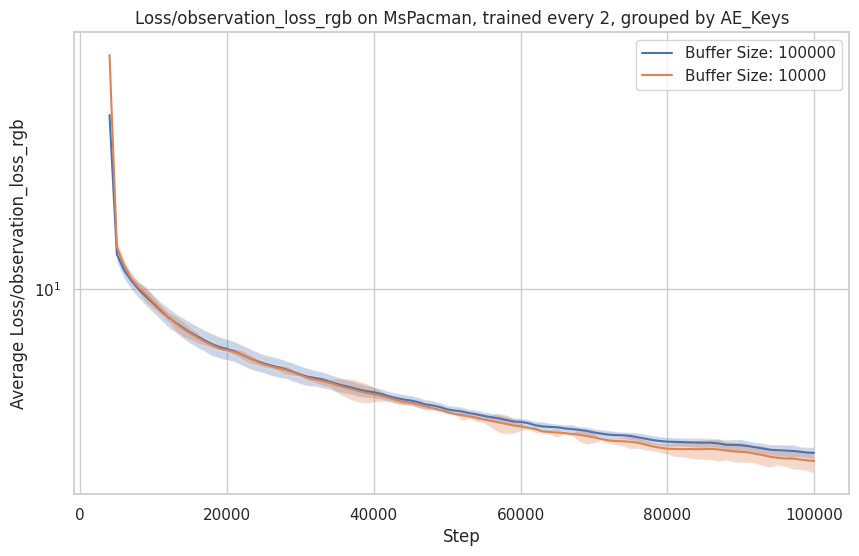

Plotting for metric: Loss/observation_loss_objects_position
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


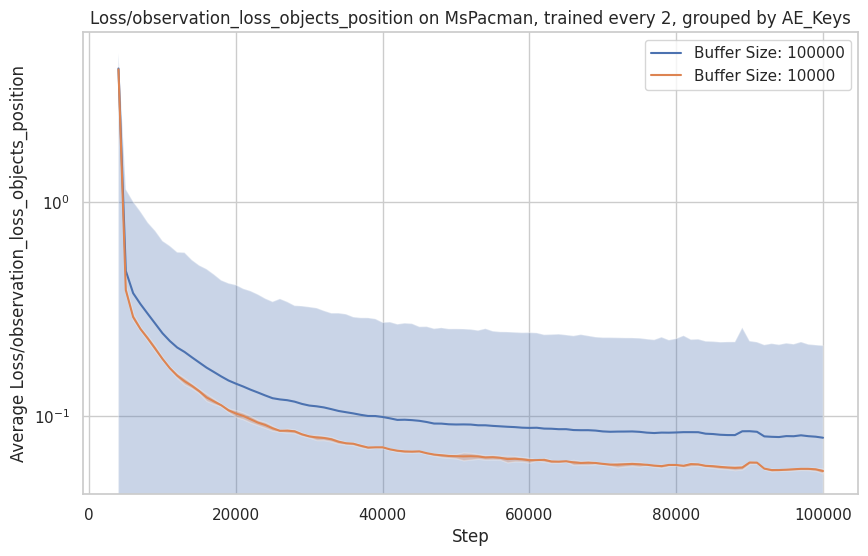

Plotting for metric: Time/sps_train
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64


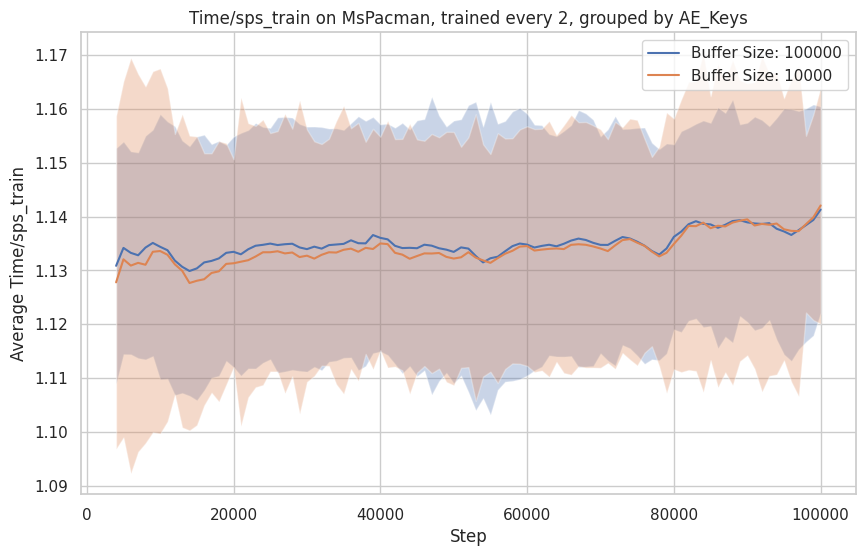

Plotting for metric: Test/cumulative_reward
Buffer_Size
10000      3
100000    17
Name: Run_ID, dtype: int64
400


In [28]:
# unique runs by Buffer_Size, filter AE_Keys = obj_autoencoding and Train_Every=2
filtered_df = all_experiments_df[(all_experiments_df['AE_Keys'] == 'rgb + obj') & (all_experiments_df['Train_Every'] == 2)]
metrics = filtered_df['Metric'].unique()
for metric in metrics:
    if metric == 'hp_metric' or metric == 'Params/exploration_amount':
        continue
    print(f"Plotting for metric: {metric}")

    # Group by Step and Metric, then calculate mean and std
    metric_df = filtered_df[(filtered_df['Metric']==metric)]
    # get number of unique run ids by group of AE_Keys
    print(metric_df.groupby('Buffer_Size')['Run_ID'].nunique())
    grouped = metric_df.drop(columns=['Run_ID', 'Metric', 'Train_Every', 'Seed']).groupby(['Step', 'Buffer_Size'])
    mean_std_df = grouped['Value'].agg(['mean', 'std']).reset_index()
    # smoothing the plot
    mean_std_df['mean'] = mean_std_df['mean'].rolling(window=5).mean()
    #mean_std_df['std'] = mean_std_df['std'].rolling(window=3).mean()


    # Plotting
    if metric == 'Test/cumulative_reward':
        print(len(metric_df))
        continue

    plt.figure(figsize=(10, 6))
    # Unique AE_Keys
    buffer_unique = filtered_df['Buffer_Size'].unique()
    for buffer in buffer_unique:
        subset = mean_std_df[mean_std_df['Buffer_Size'] == buffer]
        
        # Plot mean
        plt.plot(subset['Step'], subset['mean'], label=f'Buffer Size: {buffer}')
        
        # Fill between mean ± std
        plt.fill_between(subset['Step'], subset['mean'] - subset['std'], subset['mean'] + subset['std'], alpha=0.3)

    plt.title(f'{metric} on MsPacman, trained every 2, grouped by AE_Keys')
    plt.xlabel('Step')
    plt.ylabel(f'Average {metric}')
    # log scale for y-axis if metric contains "loss" or "grad"    
    if "Loss" in metric or "Grads" in metric:
        plt.yscale('log')
    plt.legend()
    plt.show()